## Objective
What is a fair map for Black and Latino voters?

* Where should additional 2 congressional districts be placed in Texas for fair representation of minorities?

* Do district lines dilute votes of minority voters (e.g. via cracking/packing)?


## Background & Motivation

Texas has experienced an estimated 15.9% population growth over the last decade, driven largely by Hispanic groups. This has resulted in two new congressional seats being allocated to Texas in the upcoming 2021 redistricting cycle. However, this growth has not been evenly distributed across the state. In fact, 143 of the 254 counties in Texas have experienced a declining population.

As Texas considers where to place these two new districts, it will be important to not only account for changing population patterns within the state, but also to ensure that minority groups have equal representation. In the new redistricting cycle, it is crucial to consider what a fair map looks like for Black and Latino voters.

Section II of the VRA prohibits redistricting plan that abridges any citizen's right to vote "on account of race or color (or membership in a language-minority group)." Minority groups can assess whether a map violates VRA by evaluating  whether members of the minority group have "less opportuntity than other members of the electirate to nominate and elect representatives of their choice."

Historical information from recent elections can be used in assessment VRA compliance, BUT VRA does not require that protected class must be elected in numbers _proportionate to electorate demographics_. However, Section II does stipulate that districts should be designed to allow minority groups to elect their preferred candidate, not just the candidate preferred by the majority (usually White). Thus, VRA allows for the right to replace districts where minority-preferred candidates lose with districts where candidates are given the opportunity to win if they "pull, haul, and trade to find common ground" (Johnson v De Grandy, 1994).

[Moon et al](https://mggg.org/vra) considers a district to be 'effective' for minority groups if the districts nominate (primary) and elect (generals) minority-preferred candidates (based on plurality/coalitions). Demographic targets are not explicitly considered a priori to avoid FP/FNs.

#### Summary of Demographic Changes:


https://demographics.texas.gov/Resources/Presentations/OSD/2021/2021_01_15_LeadershipNorthTexas.pdf
    
254 counties in Texas: 

* "Texas Triangle - Dallas FW, San Antonio, Houson, College Station, Austin" - 75% population

* 104 lost population from 2010-2019

Dallas -> Dallas County [County ID = 113] 
* (portions extending into Collin (085), Denton(121), Kaufman (257), & Rockwall(397) counties)
* 19% growth (+1.2M)

Houston -> Harris County [County ID = 201]
* 9.4% growth (+1.1M)

Austin -> Travis County [County ID = 453] 
* (portions extending into Hays (209) & Williamson (491) counties)
* 29.8% growth  (+0.5M)

In [2]:
import sys
import os

from functools import partial
import random

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    GeographicPartition,
    accept,
    constraints,
    updaters,
    tree
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random, PopulatedGraph, \
                            find_balanced_edge_cuts_memoization, random_spanning_tree
import maup

import networkx as nx

sys.path.insert(0, '/Users/rowanaahmed/Documents/DSSG/dssg2021-redistricting/')
import utility_functions

import warnings 
warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

## Data Exploration
#### Read & Visualize Data

##### Decision Point: Is the data sufficient for the analyses I want to run?


To compare ensembles of plans built in the last redistricting cycle based on 2010 population data to an ensemble of plans based on 2020 population data, our shapefile will require additional demographic information. The  shapefile provided by [MGGG](https://www.dropbox.com/sh/k78n2hyixmv9xdg/AABmZG5ntMbXtX1VKThR7_t8a?dl=0) needs to be augmented with more recent population data, and because the analysis is conducted prior to the release of the 2020 US Census Data, we will rely on 2019 ACS population estimates available from the [Redistricting Hub](https://redistrictingdatahub.org/dataset/texas-block-group-acs5-data-2019/) as a proxy for more current data. Data wrangling code is available in the `01_TX_data_wrangling.py` file.

The original shapefile includes racial demographic information from the 2010 census, state and federal election data from 2012, 2014, 2016, and 2018, as well as geographical information. The data is available at the Voting Tabulation District (VTD) level, which is equivalent to election precincts in Texas.
The elections data include both voting results for each of the Democratic and Republican parties in both primaries and general elections, as well as total number of  voters registered. Third party data is not available, and third party candidates historically have not had an influential impact on election results in Texas. Ecological inference techniques were used by researchers at MGGG to determine preferred candidates for each racial minority group, and the [datafiles](https://github.com/mggg/VRA_ensembles) made available by MGGG were used as is to calculate minority effective district related metrics.

The main issue faced when trying to merge more recent population data with the shapefile that only contained 2010 census data is to ensure the 2019 ACS data is correctly calculated at the VTD level. The Redistricting Hub had 2 data source options: (1) projected 2020-2030 demographic data from Haystack at _census block levels_ (N = 914,231 census blocks) and (2) 2019 ACS Survey data at _census block group levels_ (N = 15,811 census block groups).

We initially attempted to merge the projected census block data because the lower level granularity would be more likely to nest within the VTDs and allow for more accurate merging. However, this method was both much more computationally intensive, and also resulted in unreliable population estimates at the VTD level. For example, after merging the data sources, we sanity checked to see how population estimates in major metro areas changed from 2010 to 2020 based on the Haystack projects. Counterintuitively, when grouped at the county level, the data for large metro areas (e.g. Houston/Dallas) either did not indicate the large population increases we know to have occured over the past decade or actually showed decreasing populations. Thus, we decided that this proejcted data source was not reliable for use and decided to move forward with using the census block group population estimates. 

This higher level geographical unit was less computationally intensive to merge with the 9,082 VTDs, but because the ratio is close to 1:1 between the two geographical units, we cannot rely on the census block groups nesting cleanly in the VTDS. Instead, we used the [maup library](https://github.com/mggg/maup#readme) to prorate and aggregate the census block group data to VTD geographical units. When performing this prorating, generally, we would prefer to use census block level population data and avoid areal interperolation. This is because, practically, large areas in rural regions correspond to sparser population regions than smaller areas with concentrated populations. However, because we determined that the census block data from Haystack is unreliable and we knew that growth patterns since 2010 did not occur evenly across the state rendering older 2010 population data unusable, we were forced to use geographical areas to perform the prorating (refer to `01_TX_data_wrangling.py` for details).



In [6]:
state_gdf = gpd.read_file("Data/TX_VTDs_POP2019/texas_population2019.shp")
graph = Graph.from_file("Data/TX_VTDs_POP2019/texas_population2019.shp")

prec_counts = pd.read_csv('Data/mean_prec_vote_counts.csv')


/Users/rowanaahmed/opt/anaconda3/envs/gerry_chain/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1165, 1170), (7889, 8135), (603, 762), (638, 695), (6531, 6548), (6573, 6618), (7539, 7582), (763, 1812), (3500, 3510), (499, 735), (6519, 6537), (5970, 8790), (628, 629), (3871, 3886), (5974, 8790), (1159, 1168), (2981, 8790), (1806, 3877), (1114, 1154), (612, 733), (445, 446), (873, 982), (605, 639), (3496, 3505), (1663, 1686), (824, 860), (1163, 1165), (2930, 2938), (657, 658), (904, 978), (1478, 1479), (2801, 2818), (6551, 6580), (1478, 1488), (1577, 1683), (2875, 2904), (2811, 2813), (2805, 2827), (1661, 1728), (2876, 2878), (5414, 6142), (8780, 8792), (656, 714), (7457, 7526), (3505, 3510), (324, 387), (1761, 1769), (1636, 1671), (322, 344), (2984, 8790), (4608, 6563), (2817, 2828), (6539, 6608), (6591, 6609), (2778, 2818), (3544, 3550), (8743, 8748), (572, 5833), (595, 758), (362, 6405), (1113

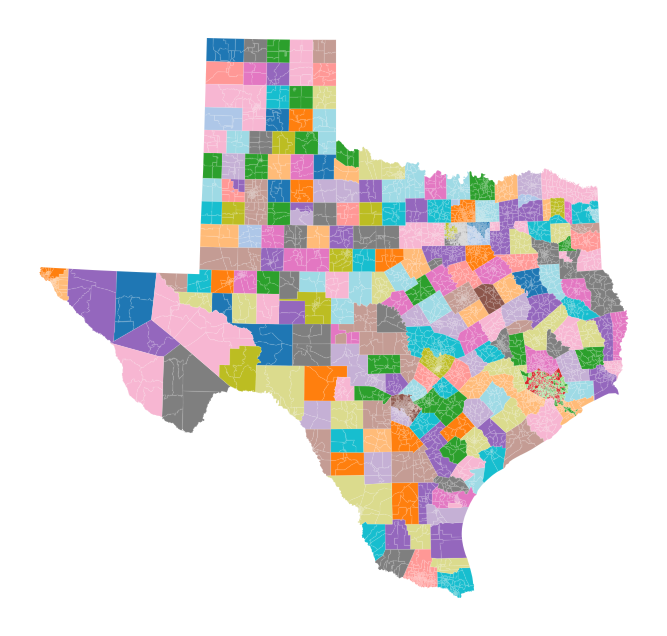

In [3]:
utility_functions.plot_district_map(state_gdf, state_gdf['CNTYVTD'].to_dict())

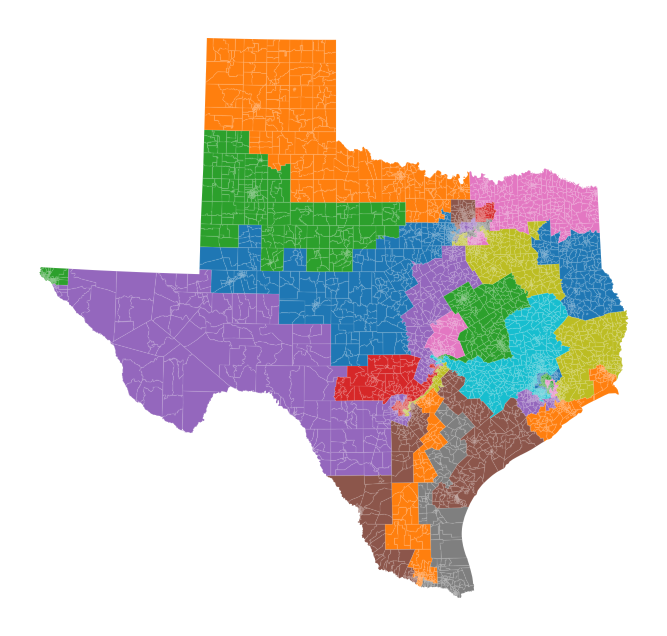

In [5]:
utility_functions.plot_district_map(state_gdf, state_gdf['CD'].to_dict())

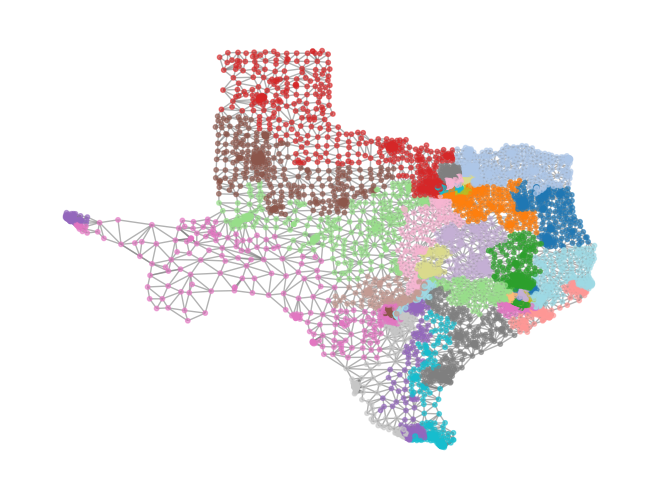

In [8]:
centroids = state_gdf.centroid
c_x = centroids.x
c_y = centroids.y

for node in graph.nodes():
    graph.nodes[node]["C_X"] = c_x[node]
    graph.nodes[node]["C_Y"] = c_y[node]
    
    
graph = utility_functions.convert_attributes_to_int(graph, ['CD'])


nx.draw(graph,
        pos = {node:(graph.nodes[node]["C_X"],graph.nodes[node]["C_Y"]) for node in graph.nodes()},
        node_color=[graph.nodes[node]["CD"] for node in graph.nodes()],
        node_size=10,cmap='tab20', alpha= 0.6, edge_color='gray')
plt.show()

## Metric Selection


##### Decision Point: Which metrics are most appropriate fro my analyses?

#### Adding 2 New Districts

Our primary objetive is to determine where the two additional districts being allocated to Texas should be placed, and to assess the varying impact of different considerations during the design process. For example, how does the decision making process change if only population patterns are accounted for versus intentionally accounting for minority effective districts during the design process. GerryChain updaters can track metric values across each step in the MCMC chain.

Below, we explore an initial ensemble to decide which counties the additional 2 districts would most likely be placed in based on **population shifts** only. This allows us to create a baseline ensemble to compare the effect of including additional constraints against.

In [5]:
#user input parameters######################################
total_steps = 1000
pop_tol = .01 #U.S. Congress (deviation from ideal district population)
start_map = 'new_seed' #CD, 'Seed_Demo', or "new_seed"
store_interval = 100  #how many Markov chain steps between data storage

#fixed parameters#################################################
num_districts_2010 = 36 #36 Congressional districts in 2010
num_districts_2019 = 38 #38 Congressional districts in 2020

DIR = ''
if not os.path.exists(DIR + 'outputs'):
    os.mkdir(DIR + 'outputs')
    
    
##################################################################
#key column names from Texas VTD shapefile
tot_pop2010 = 'TOTPOP_x'
tot_pop2019 = 'TOTPOP19'
white_pop = 'NH_WHITE'
CVAP = "1_2018"
WCVAP = "7_2018"
HCVAP = "13_2018"
BCVAP = "5_2018" #with new CVAP codes!
geo_id = 'CNTYVTD'
county_split_id = "CNTY_x"
C_X = "C_X"
C_Y = "C_Y"

Chain Components

In [154]:
#updaters #####################################
my_updaters = {
    "population2010": updaters.Tally(tot_pop2010, alias='population2010'),
    "population2019": updaters.Tally(tot_pop2019, alias='population2019'),
    "cut_edges": cut_edges
}


#acceptance functions #####################################
accept = accept.always_accept


    

## Seed Plan Selection

##### Decision Point: Will you use an existing/enacted map or a random one?

Consider 3 seed plans: 

(1) original 2013 CD plan, 

(2) random seed based on 2010 population counts & 36 districts

(3) random seed based on 2019 population counts & 38 districts

Additionally, for our modeling, we also needed to create a constrained random seed plan for 38 districts using the 2019 population counts. This constrained plan must adhere to the additional requirement of having a minimum of 11 minority effective district, which corresponds to the number of minority effective districts in the enacted 2013 CD plan. This more curated seed plan is necessary because in our subsequent modeling step, we want to run a MCMC chain that preferentially selects plans that have at least the same (or greater) number of minority effective districts as the enacted plan for ensembles that prioritizes fair representation of minority groups. This is operationalized while running the chains in the `03_TX_model.py` file by setting `ensemble_inclusion = True`. In order to start the chain, the initial parition must satisfy the ensemble_inclusion constraint, which checks that the number of minority effective districts meets the `enacted_distinct = 11` threshold. 

This initial partition is generated and added as a variable (`Seed_Demo_`) to the Texas shapefile in the `01_TX_data_wrangling.py` script by looping through a brute force method. We randomly generate recursive tree partitions with 38 districts and check at each iteration whether the inclusion constraint is met. Once a random seed satisfies the constraint, we use this as the inital partition for our 2019 MCMC chain.

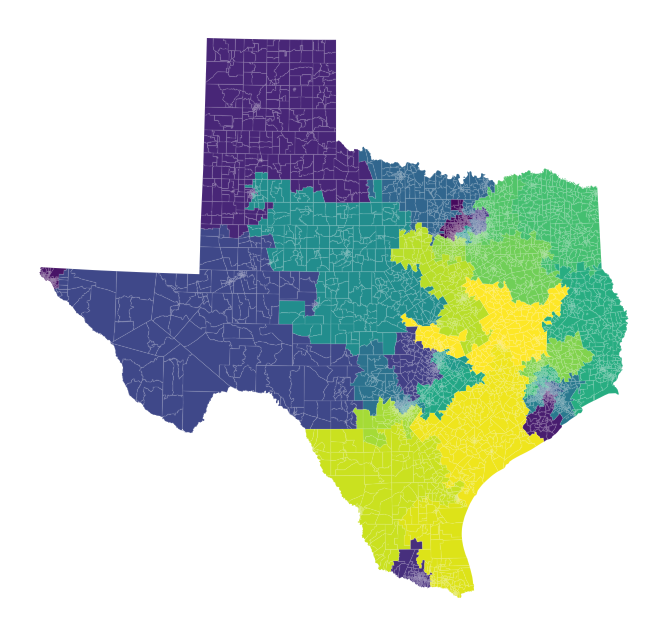

In [4]:
# inclusion constrained 2019 random seed plan (38 districts)
utility_functions.plot_district_map(state_gdf, state_gdf['Seed_Demo_'].to_dict())

In [7]:
#initial partition#######################################################

# original 2013 enacted plan based on 2010 population
CD_10_assignment = {node: int(graph.nodes()[node]['CD']) for node in graph.nodes()}
CD_10_partition = Partition(graph, CD_10_assignment, my_updaters)


# random seed plan assignments    
total_population_2010 = state_gdf[tot_pop2010].sum()
ideal_population_2010 = total_population_2010/num_districts_2010

total_population_2019 = state_gdf[tot_pop2019].sum()
ideal_population_2019 = total_population_2019/num_districts_2019
    

start_map_2010 = recursive_tree_part(graph, range(num_districts_2010), 
                                     ideal_population_2010, tot_pop2010, 
                                     pop_tol)    

start_map_2019 = recursive_tree_part(graph, range(num_districts_2019), 
                                     ideal_population_2019, tot_pop2019, 
                                     pop_tol)    

# partitions
initial_partition_2010 = GeographicPartition(graph = graph, 
                                             assignment = start_map_2010, 
                                             updaters = my_updaters)

initial_partition_2019= GeographicPartition(graph = graph, 
                                             assignment = start_map_2019, 
                                             updaters = my_updaters)

proposal_2010 = partial(
    recom, pop_col=tot_pop2010, 
    pop_target=ideal_population_2010, 
    epsilon= pop_tol, node_repeats=3
)

proposal_2019 = partial(
    recom, pop_col=tot_pop2019, 
    pop_target=ideal_population_2019, 
    epsilon= pop_tol, node_repeats=3
)

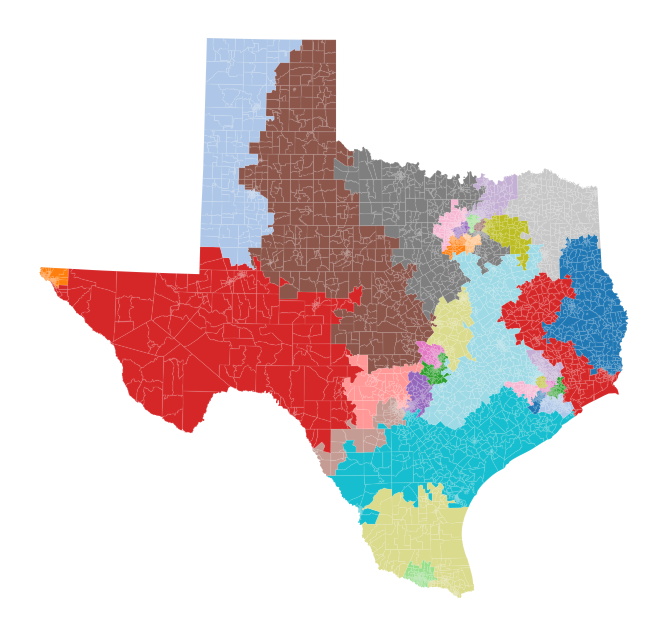

In [10]:
#2010 Seed Plan
utility_functions.plot_district_map(state_gdf, start_map_2010)

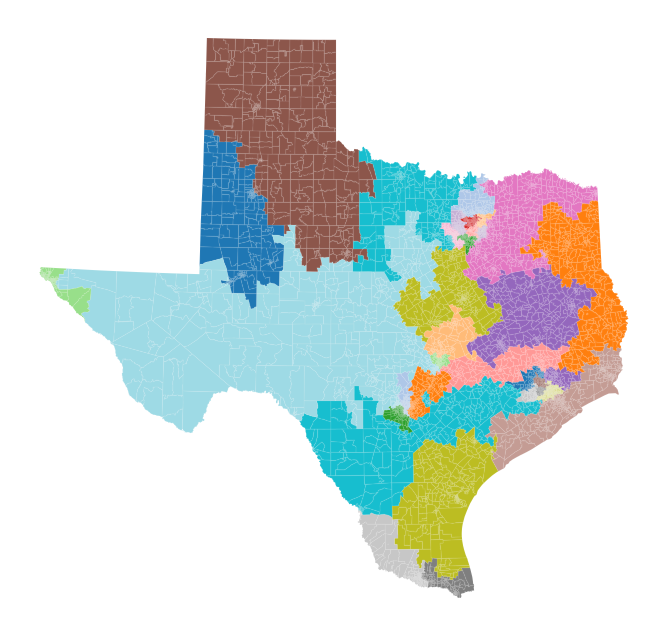

In [11]:
#2019 Seed Plan
utility_functions.plot_district_map(state_gdf, start_map_2019)

In [8]:
# map county ids to names for counties of interest
county_id2name = {113: 'Dallas County',
                  85: 'Collin County (Dallas Metro)',
                  121: 'Denton County (Dallas Metro)',
                  257: 'Kaufman County (Dallas Metro)',
                  397: 'Rockwall County (Dallas Metro)',
                  
                  201: 'Harris County',
                  157: 'Fort Bend (Houston Metro)',
                  339: 'Montgomery County (Houston Metro)',
                  
                  453: 'Travis County',
                  209: 'Hays County (Austin Metro)',
                  491: 'Williamson County (Austin Metro)'
                 }

Assess initial district distributions across counties for the 3 seed plans

In [9]:
# number of districts per target county in enacted 2010 plan
district_counts_CD = state_gdf.groupby('CNTY_x')['CD'].nunique()[list(county_id2name.keys())] 

# number of districts per target county in 2010 seed plan
state_gdf['current'] = state_gdf.index.map(start_map_2010)
district_counts_2010 = state_gdf.groupby('CNTY_x')['current'].nunique()[list(county_id2name.keys())] 

# number of districts per target county in 2019 seed plan
state_gdf['current'] = state_gdf.index.map(start_map_2019)
district_counts_2019 = state_gdf.groupby('CNTY_x')['current'].nunique()[list(county_id2name.keys())] 

district_counts = pd.DataFrame({'enacted': district_counts_CD,
                              'seed_2010': district_counts_2010,
                              'seed_2019': district_counts_2019
             })


district_counts['county_name'] = district_counts.index.map(county_id2name)
district_counts


,enacted,seed_2010,seed_2019,county_name
CNTY_x,,,,
113,6,6,7,Dallas County
85,3,5,4,Collin County (Dallas Metro)
121,2,5,4,Denton County (Dallas Metro)
257,1,2,1,Kaufman County (Dallas Metro)
397,1,1,2,Rockwall County (Dallas Metro)
201,9,9,10,Harris County
157,2,4,5,Fort Bend (Houston Metro)
339,1,3,3,Montgomery County (Houston Metro)
453,5,4,6,Travis County


In [90]:
popshift = state_gdf.groupby('CNTY_x')[['TOTPOP_x', 'TOTPOP19']].sum().loc[county_id2name.keys()]
popshift['county_name'] = popshift.index.map(county_id2name)
popshift

,TOTPOP_x,TOTPOP19,county_name
CNTY_x,,,
113,2368139.0,2.606887e+06,Dallas County
85,782341.0,9.739601e+05,Collin County (Dallas Metro)
121,662614.0,8.338424e+05,Denton County (Dallas Metro)
257,103350.0,1.238059e+05,Kaufman County (Dallas Metro)
397,78337.0,9.714795e+04,Rockwall County (Dallas Metro)
201,4092459.0,4.646431e+06,Harris County
157,585375.0,7.654457e+05,Fort Bend (Houston Metro)
339,455746.0,5.721059e+05,Montgomery County (Houston Metro)
453,1024266.0,1.226712e+06,Travis County


## Constraints

##### Decision Point: Which constraints are most important in your state?

The state's legislative requirements for redistricting should be accounted for while building ensembles of plans to ensure that only plans which satisfy the rules are included in the sampled distribution. This requires close analysis of the legislative text for each state, and then translating the text to quanitfiable constraints. 

In Texas, [redistricting rules](https://redistricting.capitol.texas.gov/reqs) require the following: 

* population balance - within 1% variation for congressional districts (_primary requirement_)
* compactness (_to the extenct practical_)
* contiguity (_to the extenct practical_)
* county line preservation (_secondary requirement_)
* districts must be drawn in a manner that neither has the purpose nor will have the effect of denying or abridging the right to vote on the basis of race, color, or language group (_primary requirement_)


For Texas, we will initially constrain plans to meet the population balance requiremnt with 1% variation. By considering geographical data at VTDs, we can ensure our districts will be reasonably compact, at least in comparison to building districts using more granular geographical units such as census blocks. Additionally, we will use the recom proposal which ensures plans are contiguous. County line preservation and VRA requirements are explored in later sections.

In [16]:
#set Markov chain parameters`
total_steps = 1000
chain_2010_CD = MarkovChain(
                proposal = proposal_2010,
                constraints = [constraints.within_percent_of_ideal_population(CD_10_partition, pop_tol, 
                                                                              pop_key='population2010')],
                accept = accept,
                initial_state = CD_10_partition,
                total_steps = total_steps
)


chain_2010 = MarkovChain(
    proposal = proposal_2010,
    constraints = [constraints.within_percent_of_ideal_population(initial_partition_2010, pop_tol, 
                                                                  pop_key='population2010')],
    accept = accept,
    initial_state = initial_partition_2010,
    total_steps = total_steps
)


chain_2019 = MarkovChain(
    proposal = proposal_2019,
    constraints = [constraints.within_percent_of_ideal_population(initial_partition_2019, pop_tol,
                                                                 pop_key='population2019'
                                                                 )],
    accept = accept,
    initial_state = initial_partition_2019,
    total_steps = total_steps
)

In [17]:
chain_dict = { 
               'random_2010': chain_2010,
               'random_2019': chain_2019,
               'enacted_2010': chain_2010_CD,
}



county_count_res = {}
for name, chain in chain_dict.items():
    print(name)
    num_districts_per_county = []
    for i, part in enumerate(chain.with_progress_bar()):
    
        state_gdf['current'] = state_gdf.index.map(part.assignment.to_dict())
        num_districts_per_county.append(state_gdf.groupby('CNTY_x')['current'].nunique())
    
    _district_count_df = pd.concat(num_districts_per_county, axis=1)
    _district_count_df.columns = range(total_steps)
    county_count_res[name] = _district_count_df

    

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/rowanaahmed/opt/anaconda3/envs/gerry_chain/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  super(GeoDataFrame, self).__setitem__(key, value)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Check convergence & compare seed plans

The plot below shows that choice of seed plan is not critical as both chains converge to similar numbers of
districts in each county after 1000 steps using the recom proposal. This also implies convergence is approaching, but due to some differences in the distribution of values (e.g. Harris County), we will run our models for 10,000 steps, which is the general rule of thumb for achieving convergene using the recom proposal.

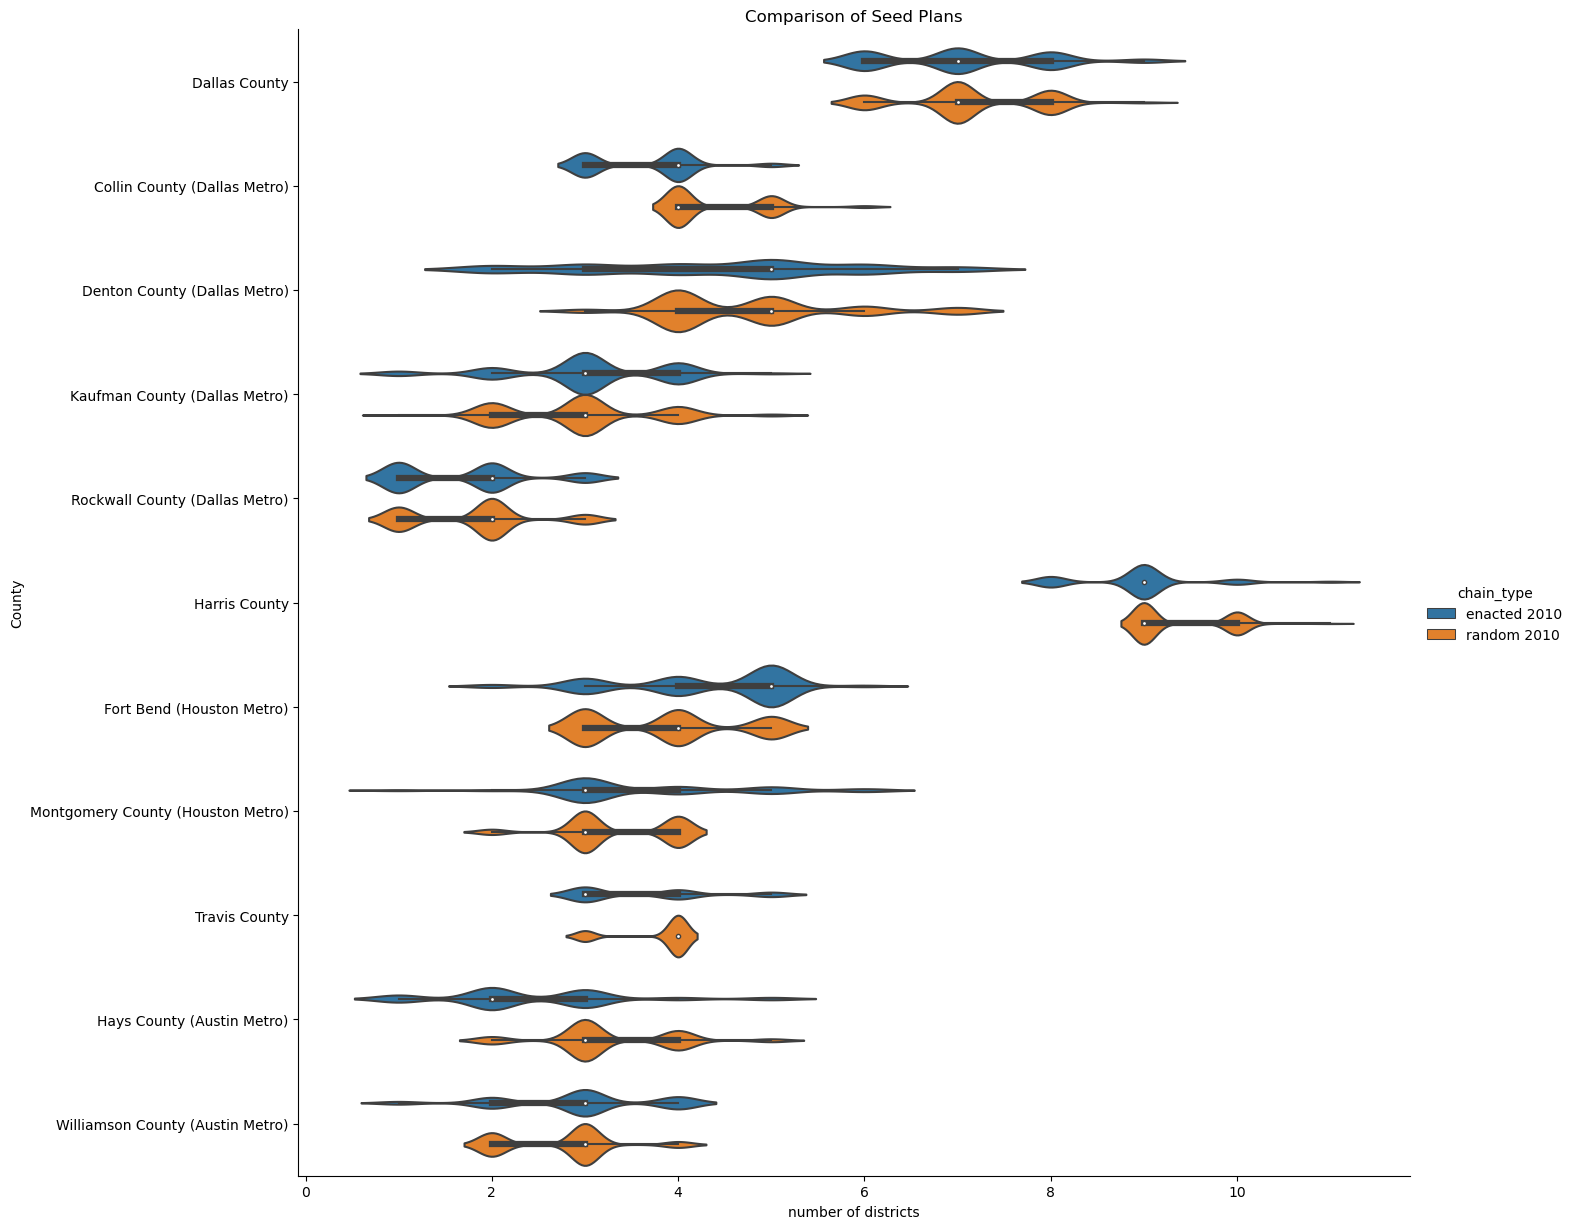

In [103]:
enacted_sub = county_count_res['enacted_2010'].loc[county_id2name.keys()]
enacted_sub['county_name'] = enacted_sub.index.map(county_id2name)
enacted_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
enacted_sub['chain_type'] = 'enacted 2010'

random_2010_sub = county_count_res['random_2010'].loc[county_id2name.keys()]
random_2010_sub['county_name'] = random_2010_sub.index.map(county_id2name)
random_2010_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
random_2010_sub['chain_type'] = 'random 2010'


res_2010 = pd.concat([enacted_sub, random_2010_sub])


# pivot to long df format for plotting
res_long = pd.melt(res_2010, 
                   id_vars=['county_name', 'region', 'chain_type'])

ax = sns.catplot(data=res_long, 
                 x='value', y='county_name', kind='violin', orient='h',
                 hue = 'chain_type', height=12, aspect=1.2
                )
ax.set(ylabel='County', 
       xlabel = 'number of districts', 
       title='Comparison of Seed Plans')
plt.show()

The figure below explores possible candidates for adding the two new districts based exclusivley on population shifts. Travis County in the Austin metro area, Rockwall County (Dallas metro), and Kaufman County (Dallas metro) may be candidates for additional districts when comparing ensembles created based on 2019 population estimates (38 districts) to ensembles based on 2010 population estimates (36 districts).

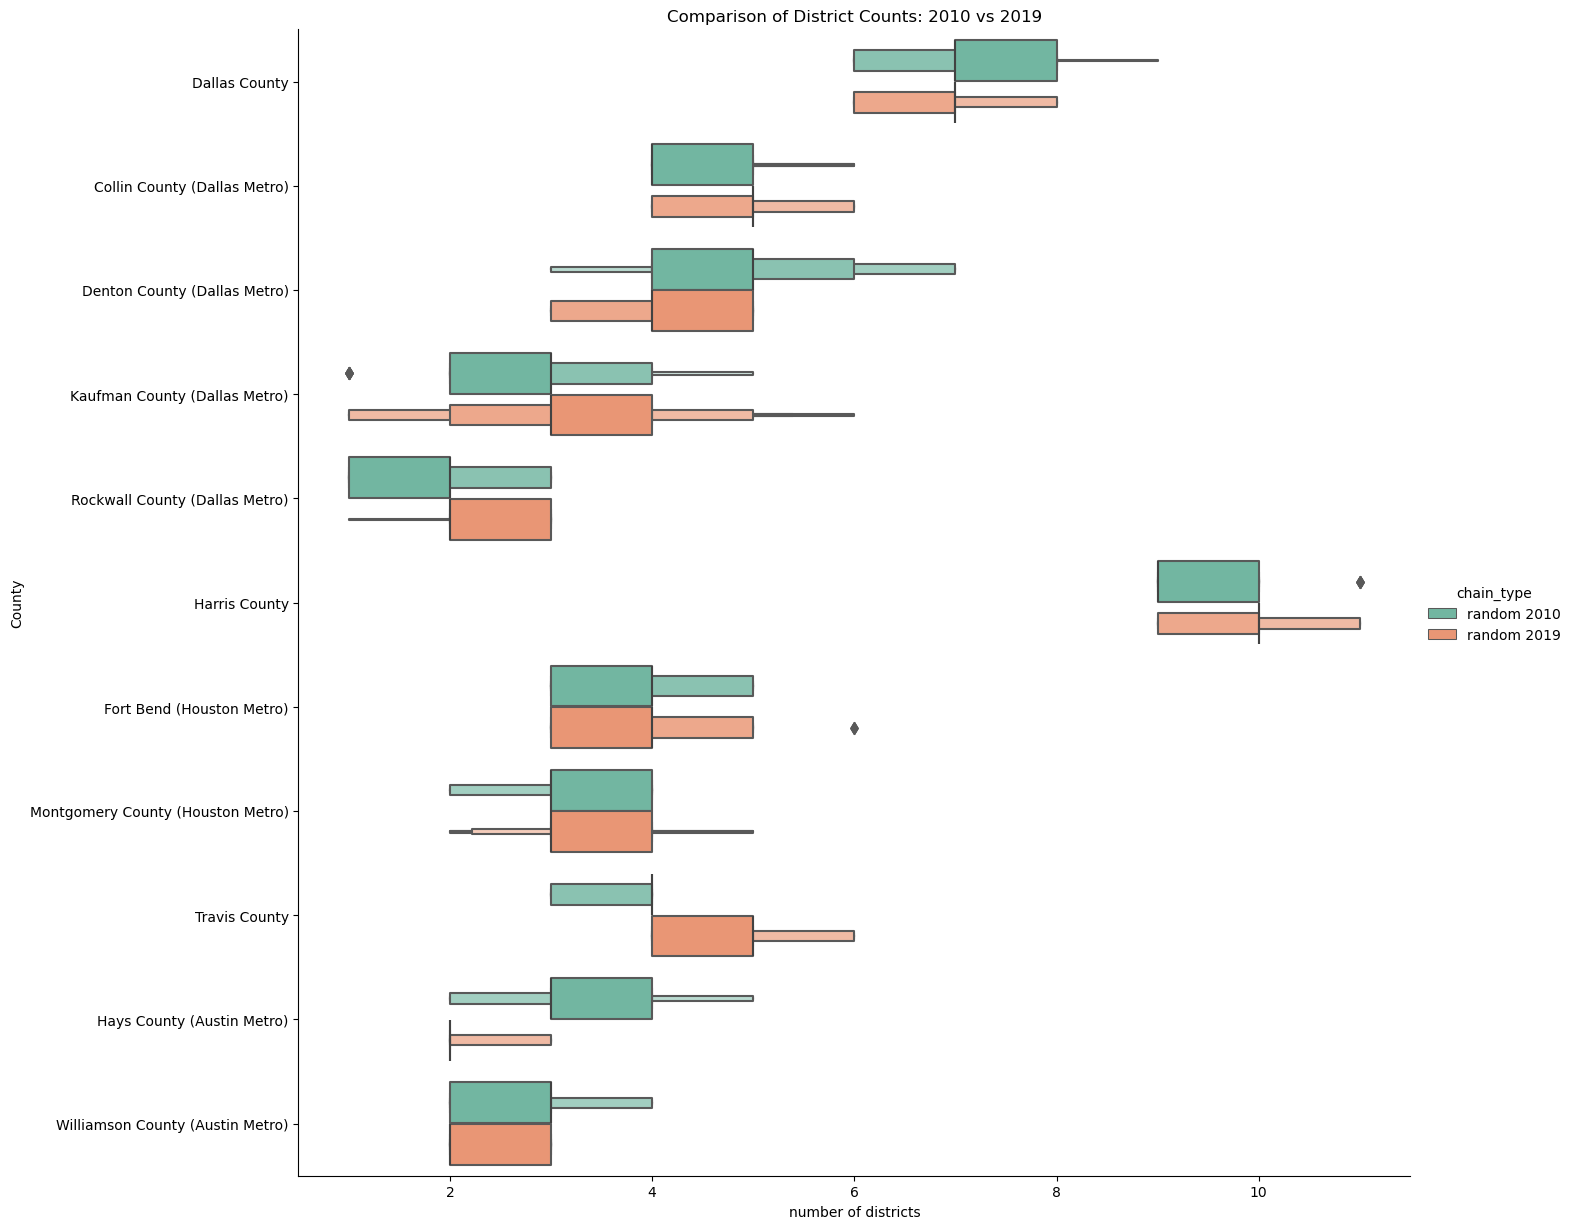

In [101]:
random_2010_sub = county_count_res['random_2010'].loc[county_id2name.keys()]
random_2010_sub['county_name'] = random_2010_sub.index.map(county_id2name)
random_2010_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
# random_2010_sub = random_2010_sub.groupby('region').sum()
random_2010_sub['chain_type'] = 'random 2010'

random_2019_sub = county_count_res['random_2019'].loc[county_id2name.keys()]
random_2019_sub['county_name'] = random_2019_sub.index.map(county_id2name)
random_2019_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
# random_2019_sub = random_2019_sub.groupby('region').sum()
random_2019_sub['chain_type'] = 'random 2019'


res_comp = pd.concat([random_2010_sub, random_2019_sub])

# pivot to long df format for plotting
res_long = pd.melt(res_comp, 
                   id_vars=['chain_type', 'region', 'county_name'])

ax = sns.catplot(data=res_long, 
                 x='value', y='county_name', kind='boxen', orient='h',
                 hue = 'chain_type', height=12, aspect=1.2, palette="Set2"
                )
ax.set(ylabel='County', 
       xlabel = 'number of districts', 
       title='Comparison of District Counts: 2010 vs 2019')
plt.show()

## Proposal Selection/Acceptance Functions

##### Decision Point: What is an appropriate proposal method (e.g. flip/recom)?
##### Decision Point: Which acceptance function will your prioritize?

#### County Split Minimization Approaches

As mentioned earlier, Texas has a strong preference for plans that preserve county lines. Becuase this is a secondary requirement, we do not want a strict constraint excluding all plans that do not meeet this goal because this would limit our sampling distributions. However, we do want to preferentially select for plans that do preserve county lines, and this can be operationalized in two ways:

Option 1) Consider acceptance function that minimizes county splits (akin to maximizing an objective function)

Option 2) Design proposal function to preserve county lines by designing recom to be county aware

In [124]:
## Consider acceptance function that prioritizes county split minimization

# alternative -> move towards plans that have fewer county splits
def minimize_county_split_accept(partition):
    
    state_gdf['prev'] = state_gdf.index.map(partition.parent.assignment.to_dict())
    state_gdf['current'] = state_gdf.index.map(partition.assignment.to_dict())

    max_split_prev = max(state_gdf.groupby('CNTY_x')['prev'].nunique())
    max_split_curr = max(state_gdf.groupby('CNTY_x')['current'].nunique())
    
    
    if max_split_curr <= max_split_prev: # accept all plans that have fewer county splits than parent plan
        return True
    
    elif random.random() < .25: # randomly accept plans that have more county splits with 25% probability
        return True
    else:
        return False
            

In [125]:
#set Markov chain parameters`
total_steps = 1000

chain_2010_min_split = MarkovChain(
    proposal = proposal_2010,
    constraints = [constraints.within_percent_of_ideal_population(initial_partition_2010, pop_tol, 
                                                                  pop_key='population2010')],
    accept = minimize_county_split_accept,
    initial_state = initial_partition_2010,
    total_steps = total_steps
)


chain_2019_min_split = MarkovChain(
    proposal = proposal_2019,
    constraints = [constraints.within_percent_of_ideal_population(initial_partition_2019, pop_tol,
                                                                 pop_key='population2019'
                                                                 )],
    accept = minimize_county_split_accept,
    initial_state = initial_partition_2019,
    total_steps = total_steps
)

In [126]:
chain_dict = { 
               'random_2010': chain_2010_min_split,
               'random_2019': chain_2019_min_split
}



county_count_res_min_split = {}
for name, chain in chain_dict.items():
    print(name)
    num_districts_per_county = []
    for i, part in enumerate(chain.with_progress_bar()):
    
        state_gdf['current'] = state_gdf.index.map(part.assignment.to_dict())
        num_districts_per_county.append(state_gdf.groupby('CNTY_x')['current'].nunique())
    
    _district_count_df = pd.concat(num_districts_per_county, axis=1)
    _district_count_df.columns = range(total_steps)
    county_count_res_min_split[name] = _district_count_df

    

random_2010


  0%|          | 0/1000 [00:00<?, ?it/s]

random_2019


  0%|          | 0/1000 [00:00<?, ?it/s]

If county preservation is also considered in our ensemble using an acceptance function, then while Travis and Rockwall are still good candidates for the new districts, Harris, Collin, or Montgomery County may be better options than Kaufman County. 

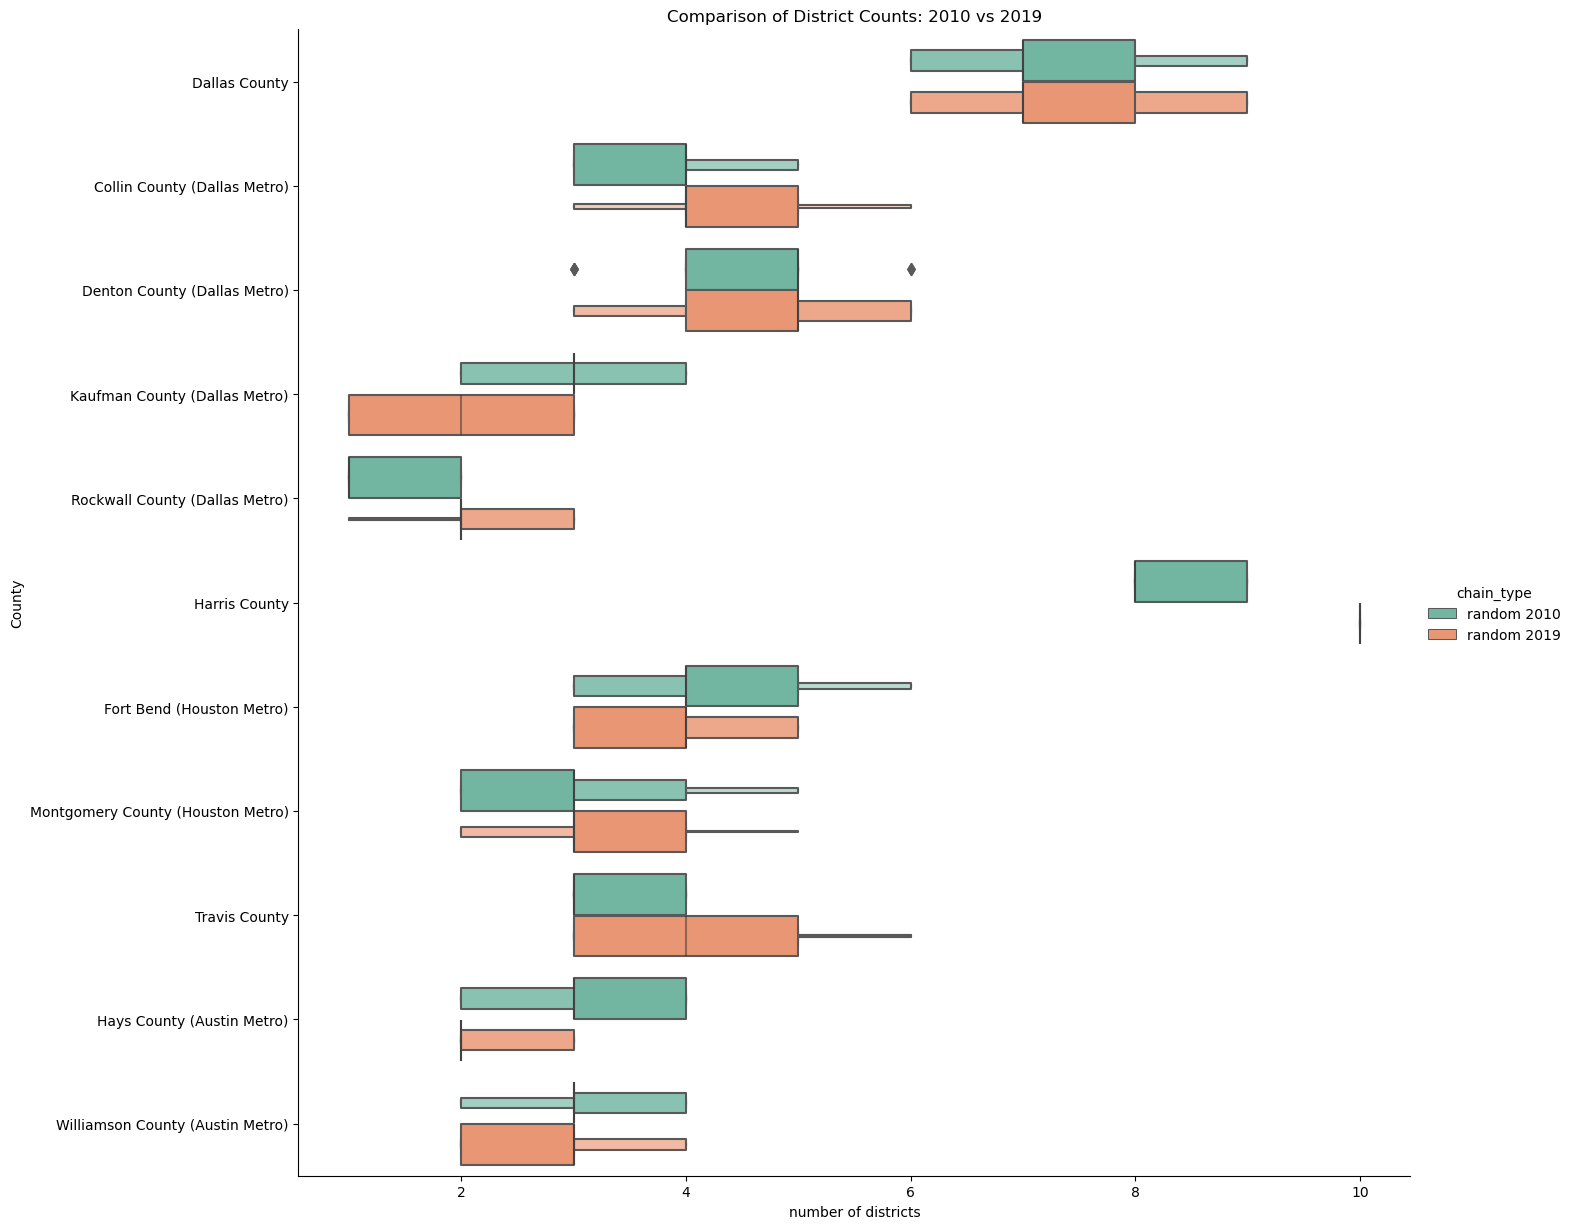

In [127]:
random_2010_sub = county_count_res_min_split['random_2010'].loc[county_id2name.keys()]
random_2010_sub['county_name'] = random_2010_sub.index.map(county_id2name)
random_2010_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
# random_2010_sub = random_2010_sub.groupby('region').sum()
random_2010_sub['chain_type'] = 'random 2010'

random_2019_sub = county_count_res_min_split['random_2019'].loc[county_id2name.keys()]
random_2019_sub['county_name'] = random_2019_sub.index.map(county_id2name)
random_2019_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
# random_2019_sub = random_2019_sub.groupby('region').sum()
random_2019_sub['chain_type'] = 'random 2019'


res_comp = pd.concat([random_2010_sub, random_2019_sub])

# pivot to long df format for plotting
res_long = pd.melt(res_comp, 
                   id_vars=['chain_type', 'region', 'county_name'])

ax = sns.catplot(data=res_long, 
                 x='value', y='county_name', kind='boxen', orient='h',
                 hue = 'chain_type', height=12, aspect=1.2, palette="Set2"
                )
ax.set(ylabel='County', 
       xlabel = 'number of districts', 
       title='Comparison of District Counts: 2010 vs 2019')
plt.show()

In [156]:
def get_spanning_tree_u_w(G):
    node_set=set(G.nodes())
    x0=random.choice(tuple(node_set))
    x1=x0
    while x1==x0:
        x1=random.choice(tuple(node_set))
    node_set.remove(x1)
    tnodes ={x1}
    tedges=[]
    current=x0
    current_path=[x0]
    current_edges=[]
    while node_set != set():
        next=random.choice(list(G.neighbors(current)))
        current_edges.append((current,next))
        current = next
        current_path.append(next)
        if next in tnodes:
            for x in current_path[:-1]:
                node_set.remove(x)
                tnodes.add(x)
            for ed in current_edges:
                tedges.append(ed)
            current_edges = []
            if node_set != set():
                current=random.choice(tuple(node_set))
            current_path=[current]
        if next in current_path[:-1]:
            current_path.pop()
            current_edges.pop()
            for i in range(len(current_path)):
                if current_edges !=[]:
                    current_edges.pop()
                if current_path.pop() == next:
                    break
            if len(current_path)>0:
                current=current_path[-1]
            else:
                current=random.choice(tuple(node_set))
                current_path=[current]
    #tgraph = Graph()
    #tgraph.add_edges_from(tedges)
    return G.edge_subgraph(tedges)


def my_uu_bipartition_tree_random(graph, pop_col, pop_target, epsilon, node_repeats=1, 
                                  spanning_tree=None, choice=random.choice):
    county_weight = 20
    populations = {node: graph.nodes[node][pop_col] for node in graph}
    possible_cuts = []
    if spanning_tree is None:
        spanning_tree = get_spanning_tree_u_w(graph)
    while len(possible_cuts) == 0:
        for edge in graph.edges():
            if graph.nodes[edge[0]]["CNTY_x"] == graph.nodes[edge[1]]["CNTY_x"]:
                graph.edges[edge]["weight"] = county_weight * random.random()
            else:
                graph.edges[edge]["weight"] = random.random()
#         spanning_tree = tree.random_spanning_tree(graph)
        spanning_tree = get_spanning_tree_u_w(graph)
        h = PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = find_balanced_edge_cuts_memoization(h, choice=choice)
    return choice(possible_cuts).subset



###PROPOSAL
tree_county_proposal_2010 = partial(recom, pop_col=tot_pop2010, 
                               pop_target=ideal_population_2010, 
                               epsilon=pop_tol, node_repeats=1, 
                               method =my_uu_bipartition_tree_random)

tree_county_proposal_2019 = partial(recom, pop_col=tot_pop2019, 
                               pop_target=ideal_population_2019, 
                               epsilon=pop_tol, node_repeats=1, 
                               method =my_uu_bipartition_tree_random)

In [157]:
#set Markov chain parameters`
total_steps = 1000

chain_2010_min_split2 = MarkovChain(
    proposal = tree_county_proposal_2010,
    constraints = [constraints.within_percent_of_ideal_population(initial_partition_2010, pop_tol, 
                                                                  pop_key='population2010')],
    accept = accept,
    initial_state = initial_partition_2010,
    total_steps = total_steps
)


chain_2019_min_split2 = MarkovChain(
    proposal = tree_county_proposal_2019,
    constraints = [constraints.within_percent_of_ideal_population(initial_partition_2019, pop_tol,
                                                                 pop_key='population2019'
                                                                 )],
    accept = accept,
    initial_state = initial_partition_2019,
    total_steps = total_steps
)

In [158]:
chain_dict = { 
               'random_2010': chain_2010_min_split2,
               'random_2019': chain_2019_min_split2
}



county_count_res_min_split2 = {}
for name, chain in chain_dict.items():
    print(name)
    num_districts_per_county = []
    for i, part in enumerate(chain.with_progress_bar()):
    
        state_gdf['current'] = state_gdf.index.map(part.assignment.to_dict())
        num_districts_per_county.append(state_gdf.groupby('CNTY_x')['current'].nunique())
    
    _district_count_df = pd.concat(num_districts_per_county, axis=1)
    _district_count_df.columns = range(total_steps)
    county_count_res_min_split2[name] = _district_count_df

random_2010


  0%|          | 0/1000 [00:00<?, ?it/s]

random_2019


  0%|          | 0/1000 [00:00<?, ?it/s]

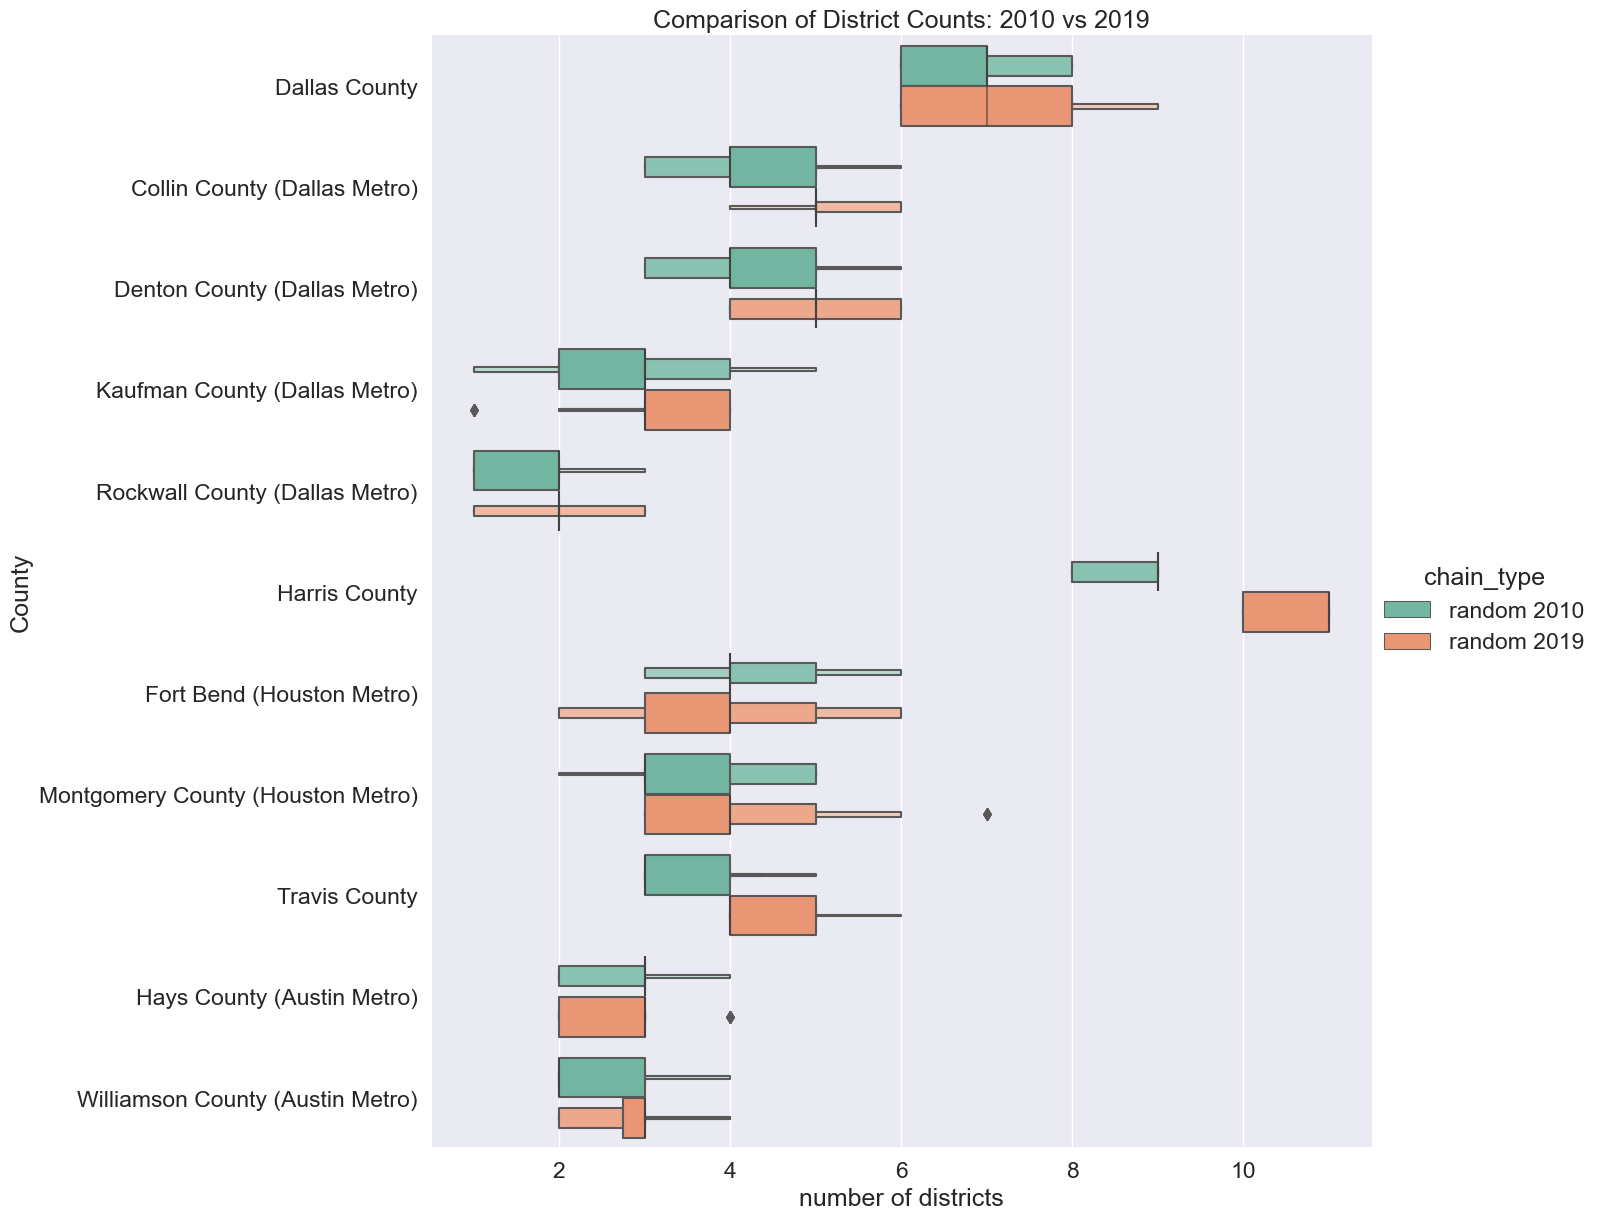

In [170]:
random_2010_sub = county_count_res_min_split2['random_2010'].loc[county_id2name.keys()]
random_2010_sub['county_name'] = random_2010_sub.index.map(county_id2name)
random_2010_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
# random_2010_sub = random_2010_sub.groupby('region').sum()
random_2010_sub['chain_type'] = 'random 2010'

random_2019_sub = county_count_res_min_split2['random_2019'].loc[county_id2name.keys()]
random_2019_sub['county_name'] = random_2019_sub.index.map(county_id2name)
random_2019_sub['region'] = ['Dallas Metro']*5 + ['Houston Metro']*3 + ['Austin Metro']*3
# random_2019_sub = random_2019_sub.groupby('region').sum()
random_2019_sub['chain_type'] = 'random 2019'


res_comp = pd.concat([random_2010_sub, random_2019_sub])

# pivot to long df format for plotting
res_long = pd.melt(res_comp, 
                   id_vars=['chain_type', 'region', 'county_name'])

sns.set(font_scale=1.5) 
ax = sns.catplot(data=res_long, 
                 x='value', y='county_name', kind='boxen', orient='h',
                 hue = 'chain_type', height=12, aspect=1.2, palette="Set2"
                )
ax.set(ylabel='County', 
       xlabel = 'number of districts', 
       title='Comparison of District Counts: 2010 vs 2019')
plt.show()

The alternative county-aware recom tree proposal results in fewer county splits based on the comparison of the three distributions visualized in the boxplots (always accept, minimize county split accept, and modified recom). The modified recom proposal method results in narrower ranges for number of districts per county, and skews towards lower values than the other two methods. **Thus, for our modeling we will account for county line preservation goals by incorporating the county-aware recom tree proposal into our chain structure.**